In [2]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel

import shapely.wkt as shpwkt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [145]:
DATA = '../data'
yelp_cluster = pd.read_csv(DATA + '/Yelp_Weights.csv', index_col=0)

yelp_cluster['geometry'] = yelp_cluster['geometry'].apply(lambda x: shpwkt.loads(x))
yelp_cluster = gpd.GeoDataFrame(yelp_cluster, geometry='geometry')
yelp_cluster.crs = {'init': 'epsg:4326'}

yelp_cluster.head()

,FIPS,geometry,Total,asian,european,halal,hispanic,midmed,Armenian,Cambodian,...,Puerto Rican,Russian,Salvadoran,Shanghainese,Singaporean,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,36085000900,POLYGON ((-74.07920577013245 40.64343078374567...,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,36061009800,POLYGON ((-73.96432543478758 40.75638153099091...,4,3,4,3,3,4,0,0,...,2,0,0,1,0,2,3,2,2,2
2,36061010000,POLYGON ((-73.96802436915851 40.75957814005282...,4,3,4,3,4,4,0,0,...,1,0,0,1,0,1,4,3,2,2
3,36061010200,POLYGON ((-73.97124277307127 40.76093641847906...,4,3,4,4,4,4,0,0,...,1,0,0,2,0,1,3,2,2,1
4,36061010400,POLYGON ((-73.97445730550224 40.76229308352487...,4,3,4,4,4,4,0,0,...,0,2,0,1,0,1,3,2,1,2


In [146]:
# total number of ethnicities
cats = yelp_cluster.max()[8:]
len(cats)

41

In [147]:
# how many ethnicities left if we remove those with only 3 or fewer categories
(cats > 2).sum()

33

In [148]:
cats[cats <= 2].index

Index([u'Armenian', u'Filipino', u'Haitian', u'Himalayan Nepalese',
       u'Lebanese', u'Moroccan', u'Polish', u'Singaporean'],
      dtype='object')

In [149]:
yelp_cluster.drop([u'Armenian', u'Filipino', u'Haitian', u'Himalayan Nepalese',
                   u'Lebanese', u'Moroccan', u'Polish', u'Singaporean'],axis=1,inplace=True)
yelp_cluster.columns

Index([u'FIPS', u'geometry', u'Total', u'asian', u'european', u'halal',
       u'hispanic', u'midmed', u'Cambodian', u'Caribbean', u'Chinese',
       u'Colombian', u'Cuban', u'Dominican', u'French', u'German', u'Greek',
       u'Halal', u'Indian', u'Irish', u'Italian', u'Japanese', u'Jewish',
       u'Korean', u'Kosher', u'Latin American', u'Malaysian', u'Mediterranean',
       u'Mexican', u'Middle Eastern', u'Pakistani', u'Peruvian',
       u'Puerto Rican', u'Russian', u'Salvadoran', u'Shanghainese',
       u'Taiwanese', u'Thai', u'Turkish', u'Venezuelan', u'Vietnamese'],
      dtype='object')

In [150]:
# yelp_cluster.to_csv(DATA + '/Yelp_Weights_subset.csv', index=0)

In [159]:
X = yelp_cluster.iloc[:,8:41]
X.head(1)

,Cambodian,Caribbean,Chinese,Colombian,Cuban,Dominican,French,German,Greek,Halal,...,Peruvian,Puerto Rican,Russian,Salvadoran,Shanghainese,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,0,1,1,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0


In [190]:
range_n_clusters = range(2,10)
for n in range_n_clusters:
    #19900
    gmm = GaussianMixture(n_components=n,random_state=3391)
    res = gmm.fit(X)
    silhouette_avg = silhouette_score(X, res.predict(X))
    print("For n_clusters = {},".format(n)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.257827931824
For n_clusters = 3, the average silhouette_score is : 0.118604278852
For n_clusters = 4, the average silhouette_score is : 0.178688153804
For n_clusters = 5, the average silhouette_score is : 0.104426074539
For n_clusters = 6, the average silhouette_score is : 0.211872551385
For n_clusters = 7, the average silhouette_score is : 0.240221382689
For n_clusters = 8, the average silhouette_score is : 0.226382953224
For n_clusters = 9, the average silhouette_score is : 0.221490435104


In [174]:
0.240221382689

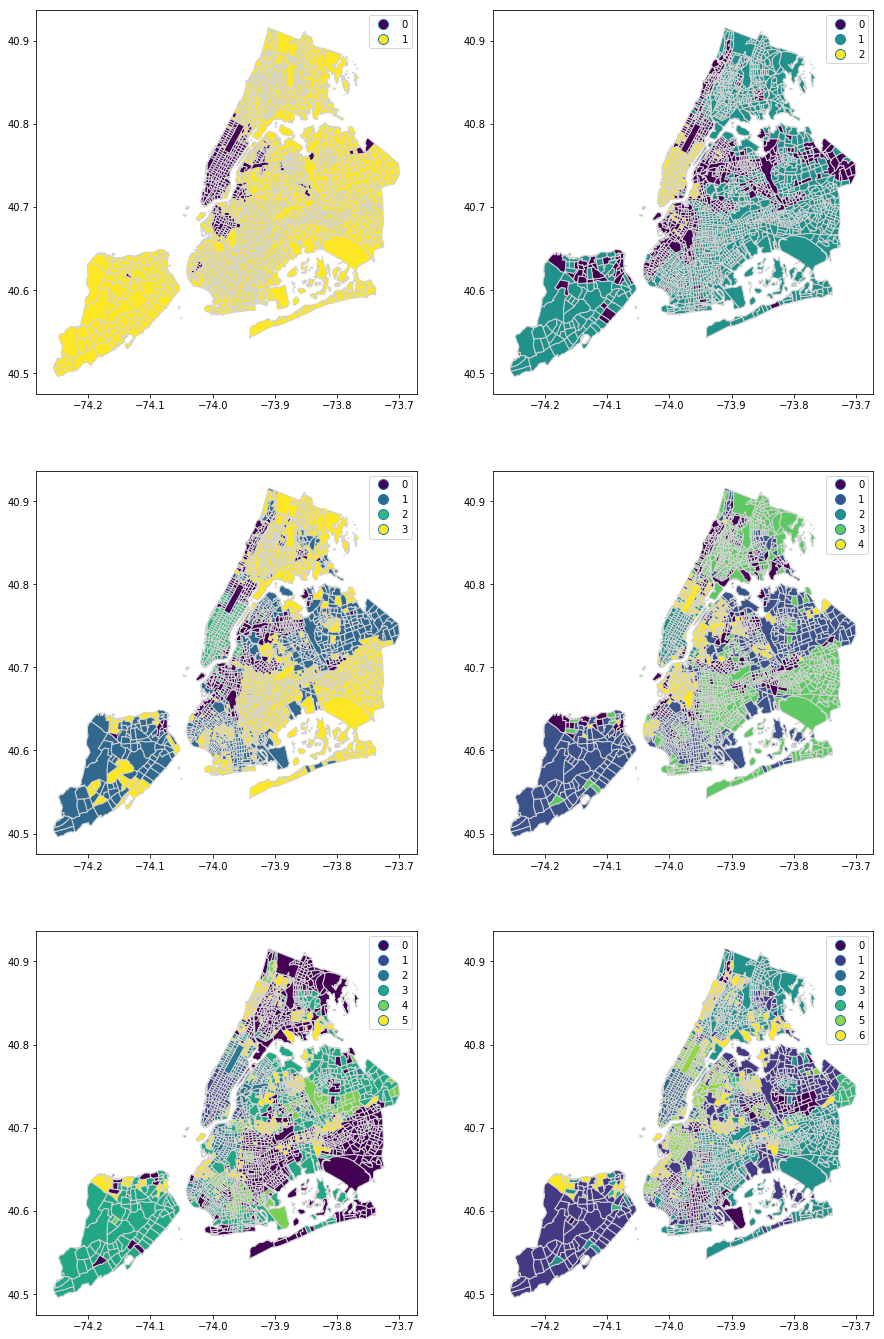

In [191]:
fig = plt.figure(figsize=(15,24))
for n in range(2,8):
    X = yelp_cluster.iloc[:,8:41]
    km = KMeans(random_state=3391, n_clusters=n)
    res = km.fit(X)

    yelp_cluster['label'] = res.labels_
    X['label'] = res.labels_
    
    ax = fig.add_subplot(319+n)
    yelp_cluster.plot(ax=ax, column='label', cmap='viridis', legend=True, categorical=True, edgecolor='lightgray')

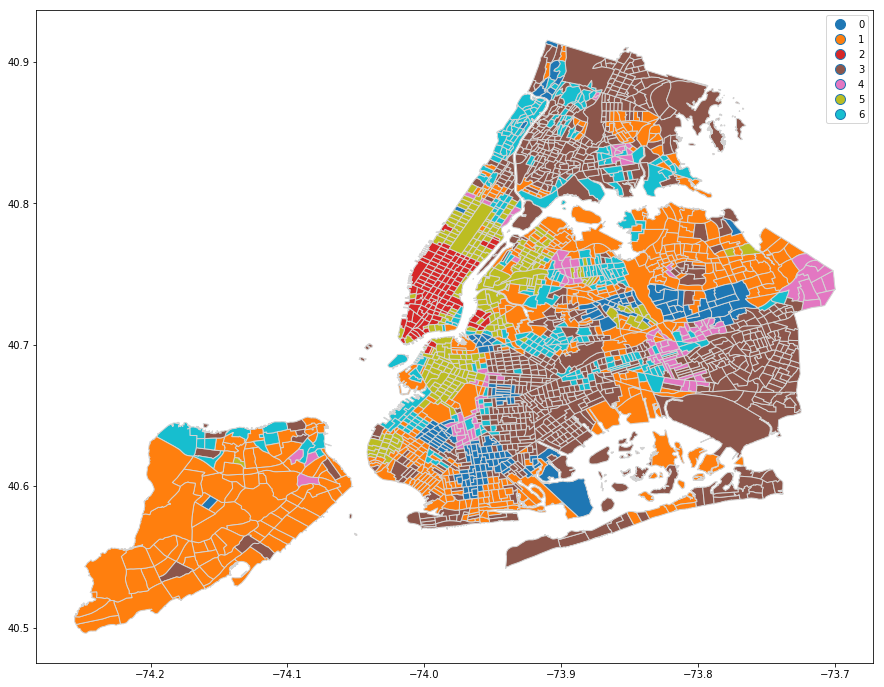

In [193]:
X = yelp_cluster.iloc[:,8:41]
km = KMeans(random_state=3391, n_clusters=7)
res = km.fit(X)

yelp_cluster['label'] = res.labels_
X['label'] = res.labels_

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
yelp_cluster.plot(ax=ax, column='label', cmap='tab10', legend=True, categorical=True, edgecolor='lightgray')

In [197]:
# dfs = []
# for i in range(n):
#     dfs.append(yelp_cluster[yelp_cluster['label'] == i].mean())
# label_df = pd.concat(dfs, axis=1)
# # label_df.columns = ['Domin/Latin', 'Manhattan', 'Cari/S.Asia', 'Cari/Black', 'UPPER/DTBL', 'Asian', 'Jewish']
# label_df

yelp_cluster.groupby('label').mean().iloc[:,1:].T

label,0,1,2,3,4,5,6
Total,0.905660,0.933902,3.632479,0.064267,1.283186,2.234310,0.962199
asian,0.666667,1.176972,3.213675,0.163239,1.663717,1.836820,0.831615
european,1.905660,1.068230,3.692308,0.159383,0.566372,2.058577,0.567010
halal,0.515723,0.622601,2.692308,0.160668,1.929204,1.527197,0.381443
hispanic,0.433962,0.522388,3.427350,0.443445,1.230088,2.259414,1.800687
midmed,0.465409,0.744136,3.350427,0.087404,0.407080,1.866109,0.305842
Cambodian,0.000000,0.000000,0.376068,0.011568,0.000000,0.016736,0.020619
Caribbean,0.358491,0.196162,0.641026,1.019280,1.362832,0.543933,0.690722
Chinese,0.767296,1.264392,2.376068,0.347044,1.371681,1.589958,1.250859
Colombian,0.094340,0.174840,0.042735,0.033419,0.221239,0.422594,0.350515


In [73]:
# Gaussian Kernel SVM, aka "Radial Basis Function" or "RBF".
# Gamma is an extra bandwidth parameter
clf = svm.SVC(kernel='rbf', gamma=1) 
clf.fit(X)

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=1)
clf.fit(X_train)

TypeError: fit() takes at least 3 arguments (2 given)

In [ ]:


# Plot the line, the points, and the nearest vectors to the plane

plt.clf()

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            facecolors='none', zorder=10) # plot support vectors with small circle

plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired) # plot X,Y


#####################################################################################
plt.axis('tight')
x_min = -1.5
x_max = 1.5
y_min = -1.5
y_max = 1.5

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # all the points in the plane
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]) # put them in the desion function

# Put the result into a color plot
Z = Z.reshape(XX.shape)

plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired) # Make a color for all the points in plane by our decision function.

plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
            levels=[-.5, 0, .5])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

print "In sample, we successfully predict {} percent of the data".format(100.0*(clf.predict(X)==Y).sum()/len(Y))

what is normal/abnormal pattern？

In [2]:
# read data
data = pd.read_csv("../data/Yelp_Weights.csv")
data.head()

,Unnamed: 0,FIPS,geometry,Total,asian,european,halal,hispanic,midmed,Armenian,...,Puerto Rican,Russian,Salvadoran,Shanghainese,Singaporean,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,0,36085000900,POLYGON ((-74.07920577013245 40.64343078374567...,1,1,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,36061009800,POLYGON ((-73.96432543478758 40.75638153099091...,4,4,4,3,3,4,0,...,1,0,0,1,0,1,3,2,1,1
2,2,36061010000,POLYGON ((-73.96802436915851 40.75957814005282...,4,4,4,2,4,4,0,...,1,0,0,1,0,0,4,3,1,2
3,3,36061010200,POLYGON ((-73.97124277307127 40.76093641847906...,4,4,4,4,4,4,0,...,1,0,0,2,0,1,3,2,1,1
4,4,36061010400,POLYGON ((-73.97445730550224 40.76229308352487...,4,4,4,3,4,3,0,...,0,2,0,1,0,0,3,2,1,1


In [68]:
data.columns

Index(['Unnamed: 0', 'FIPS', 'geometry', 'Total', 'asian', 'european', 'halal',
       'hispanic', 'midmed', 'Armenian', 'Cambodian', 'Caribbean', 'Chinese',
       'Colombian', 'Cuban', 'Dominican', 'Filipino', 'French', 'German',
       'Greek', 'Haitian', 'Halal', 'Himalayan Nepalese', 'Indian', 'Irish',
       'Italian', 'Japanese', 'Jewish', 'Korean', 'Kosher', 'Latin American',
       'Lebanese', 'Malaysian', 'Mediterranean', 'Mexican', 'Middle Eastern',
       'Moroccan', 'Pakistani', 'Peruvian', 'Polish', 'Puerto Rican',
       'Russian', 'Salvadoran', 'Shanghainese', 'Singaporean', 'Taiwanese',
       'Thai', 'Turkish', 'Venezuelan', 'Vietnamese'],
      dtype='object')

In [3]:
X = data[[
    'asian', 'european', 'halal',
       'hispanic', 'midmed'
]]

In [ ]:
'Armenian',
 'Cambodian',
 'Chinese',
 'Colombian',
 'Cuban',
 'Dominican',
 'Filipino',
 'French',
 'German',
 'Greek',
 'Haitian',
 'Indian',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Lebanese',
 'Malaysian',
 'Mexican',
 'Moroccan',
 'Pakistani',
 'Peruvian',
 'Polish',
 'Russian',
 'Salvadoran',
 'Taiwanese',
 'Thai',
 'Turkish',
 'Venezuelan',
 'Vietnamese'

In [61]:
X = data[[
 'Yelp_asian',
 'Yelp_european',
 'Yelp_halal',
 'Yelp_hispanic',
 'Yelp_midmed',
]]

In [80]:
for col in X.columns[:]:
    X[col] = pd.to_numeric(X[col], errors="coerce")

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
X.sum()

asian       3193
european    2081
halal       1295
hispanic    2263
midmed      1145
dtype: int64

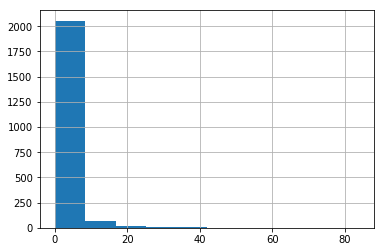

In [64]:
X['Yelp_asian'].hist()

In [72]:
print("Missing data: %.2f %%"%((1 - len(X.dropna()) / len(X)) * 100))
X.isnull().sum()

Missing data: 0.00 %


Armenian              0
Cambodian             0
Caribbean             0
Chinese               0
Colombian             0
Cuban                 0
Dominican             0
Filipino              0
French                0
German                0
Greek                 0
Haitian               0
Halal                 0
Himalayan Nepalese    0
Indian                0
Irish                 0
Italian               0
Japanese              0
Jewish                0
Korean                0
Kosher                0
Latin American        0
Lebanese              0
Malaysian             0
Mediterranean         0
Mexican               0
Middle Eastern        0
Moroccan              0
Pakistani             0
Peruvian              0
Polish                0
Puerto Rican          0
Russian               0
Salvadoran            0
Shanghainese          0
Singaporean           0
Taiwanese             0
Thai                  0
Turkish               0
Venezuelan            0
Vietnamese            0
dtype: int64

In [59]:
# drop NAs
X.dropna(how='any', inplace=True)
X.reset_index(drop=True, inplace=True)
X.head()

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ACS_Armenian,ACS_Cambodian,ACS_Chinese,ACS_Colombian,ACS_Cuban,ACS_Dominican,ACS_Filipino,ACS_French,ACS_German,ACS_Greek,...,Yelp_Pakistani,Yelp_Peruvian,Yelp_Polish,Yelp_Russian,Yelp_Salvadoran,Yelp_Taiwanese,Yelp_Thai,Yelp_Turkish,Yelp_Venezuelan,Yelp_Vietnamese
0,0.0000,0.0,0.519792,0.106624,0.279888,5.077969,0.000000,0.0000,0.399840,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0000,0.0,0.000000,1.237859,0.190440,12.816606,0.000000,0.0000,0.856980,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0000,0.0,0.000000,0.000000,1.521739,13.244147,0.384615,0.0000,0.167224,0.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1321,0.0,0.000000,0.000000,1.469617,29.920740,0.000000,0.1321,0.148613,0.066050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0000,0.0,0.372856,0.633855,0.000000,17.002237,0.149142,0.0000,1.491424,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
for i in range(len(X.columns)):
    X.iloc[:,i] = X.iloc[:,i] / X['Yelp_Total']

/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [40]:
X.head()

,Yelp_Total,Yelp_Armenian,Yelp_Cambodian,Yelp_Caribbean,Yelp_Chinese,Yelp_Colombian,Yelp_Cuban,Yelp_Dominican,Yelp_Filipino,Yelp_French,...,Yelp_Puerto Rican,Yelp_Russian,Yelp_Salvadoran,Yelp_Shanghainese,Yelp_Singaporean,Yelp_Taiwanese,Yelp_Thai,Yelp_Turkish,Yelp_Venezuelan,Yelp_Vietnamese
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
range_n_clusters = range(2,10)
for n in range_n_clusters:
    gmm = GaussianMixture(n_components=n,random_state=100)
    res = gmm.fit(X)
    silhouette_avg = silhouette_score(X, res.predict(X))
    print("For n_clusters = {},".format(n)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.34310725729564784
For n_clusters = 3, the average silhouette_score is : 0.2141949221469151
For n_clusters = 4, the average silhouette_score is : 0.1865926696110279
For n_clusters = 5, the average silhouette_score is : 0.1865684644445253
For n_clusters = 6, the average silhouette_score is : 0.1781984528124823
For n_clusters = 7, the average silhouette_score is : 0.16456585885707445
For n_clusters = 8, the average silhouette_score is : 0.1614880467728562
For n_clusters = 9, the average silhouette_score is : 0.16649236544454551


In [212]:
df = pd.read_csv("../data/Classifed_CensusTracts.csv")
df.head()

,FIPS,Census Tract,Pop Density,Income,Age,Household Size,Total Pop,ACS_Mexican,ACS_Cuban,ACS_Dominican,...,Yelp_Russian,Yelp_Salvadoran,Yelp_Shanghainese,Yelp_Singaporean,Yelp_Taiwanese,Yelp_Thai,Yelp_Turkish,Yelp_Venezuelan,Yelp_Vietnamese,label
0,36005000100,100.0,11586.310,NaN,32.1,NaN,7503.0,1.865920,0.279888,5.077969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,36005000200,200.0,28365.120,70893.0,38.6,3.94,5251.0,3.865930,0.190440,12.816606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,36005000400,400.0,20096.470,76667.0,39.4,3.10,5980.0,1.672241,1.521739,13.244147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,36005001600,1600.0,32334.870,31540.0,36.9,2.94,6056.0,0.577939,1.469617,29.920740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,36005001900,1900.0,4164.445,39130.0,32.5,2.27,2682.0,4.809843,0.000000,17.002237,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


In [213]:
df.columns

Index([u'FIPS', u'Census Tract', u'Pop Density', u'Income', u'Age',
       u'Household Size', u'Total Pop', u'ACS_Mexican', u'ACS_Cuban',
       u'ACS_Dominican', u'ACS_Salvadoran', u'ACS_Colombian', u'ACS_Peruvian',
       u'ACS_Venezuelan', u'ACS_Indian', u'ACS_Cambodian', u'ACS_Chinese',
       u'ACS_Filipino', u'ACS_Japanese', u'ACS_Korean', u'ACS_Laotian',
       u'ACS_Malaysian', u'ACS_Nepalese', u'ACS_Pakistani', u'ACS_Taiwanese',
       u'ACS_Thai', u'ACS_Vietnamese', u'ACS_Lebanese', u'ACS_Moroccan',
       u'ACS_Armenian', u'ACS_French', u'ACS_German', u'ACS_Greek',
       u'ACS_Irish', u'ACS_Italian', u'ACS_Polish', u'ACS_Russian',
       u'ACS_Turkish', u'ACS_Haitian', u'ACS_White',
       u'ACS_Black or African American',
       u'ACS_American Indian and Alaska Native', u'ACS_Asian',
       u'ACS_Hispanic or Latino', u'PlaceFIPS', u'TractFIPS', u'Place_TractID',
       u'DIABETES_CrudePrev', u'HIGHCHOL_CrudePrev', u'OBESITY_CrudePrev',
       u'Yelp_Total', u'Yelp_asian', 

In [214]:
X = df[[u'Pop Density', u'Income', u'Age',
       u'Household Size', u'Total Pop',
       u'DIABETES_CrudePrev', u'HIGHCHOL_CrudePrev',
       u'OBESITY_CrudePrev', u'label']]
X.head()

,Pop Density,Income,Age,Household Size,Total Pop,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev,label
0,11586.310,NaN,32.1,NaN,7503.0,9.9,27.8,35.4,1
1,28365.120,70893.0,38.6,3.94,5251.0,12.7,33.8,29.9,6
2,20096.470,76667.0,39.4,3.10,5980.0,11.2,31.4,29.4,3
3,32334.870,31540.0,36.9,2.94,6056.0,17.0,37.8,34.5,6
4,4164.445,39130.0,32.5,2.27,2682.0,11.4,30.8,33.0,6


In [215]:
X.dropna(inplace=True)

/Users/Yuwen/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [216]:
for col in X.columns[:-1]:
    X[col] = pd.cut(X[col],7,labels=[0,1,2,3,4,5,6])
X.head()

/Users/Yuwen/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pop Density,Income,Age,Household Size,Total Pop,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev,label
1,0,1,2,3,1,2,3,4,6
2,0,1,2,2,1,2,2,3,3
3,0,0,2,2,1,3,3,5,6
4,0,0,2,1,0,2,2,4,6
5,1,0,2,2,2,3,3,5,3


In [217]:
hc = HillClimbSearch(X, scoring_method=BicScore(X))
best_model = hc.estimate()
print(best_model.edges())

[('Pop Density', 'Total Pop'), ('OBESITY_CrudePrev', 'Age'), ('OBESITY_CrudePrev', 'label'), ('DIABETES_CrudePrev', 'HIGHCHOL_CrudePrev'), ('DIABETES_CrudePrev', 'OBESITY_CrudePrev'), ('Income', 'Pop Density'), ('Income', 'DIABETES_CrudePrev'), ('label', 'Household Size')]


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=3651000.0, right=3651000.0
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3651000.0, top=3651000.0
  'bottom=%s, top=%s') % (bottom, top))


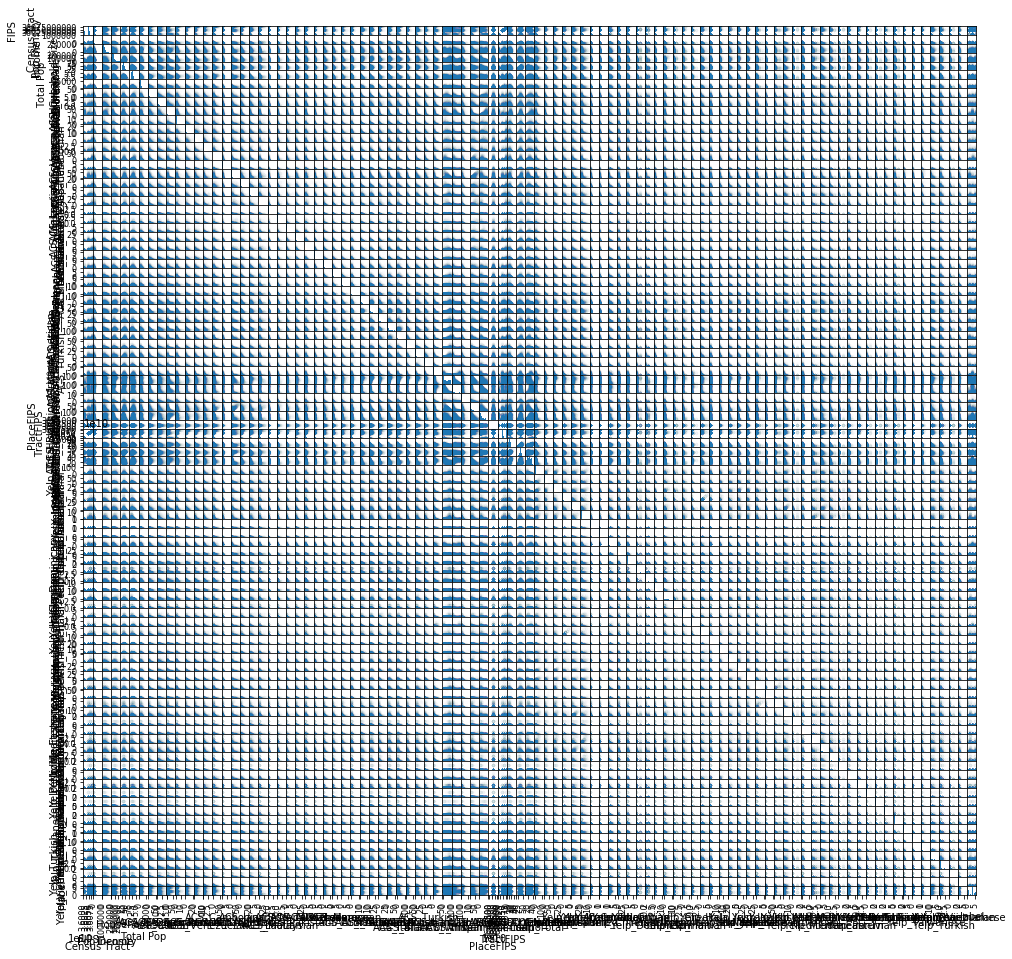

In [222]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.006, figsize=(16, 16), diagonal='hist');

In [225]:
corr_tab2 = df.corr()
corr_tab2.to_csv("corr_tab2.csv")

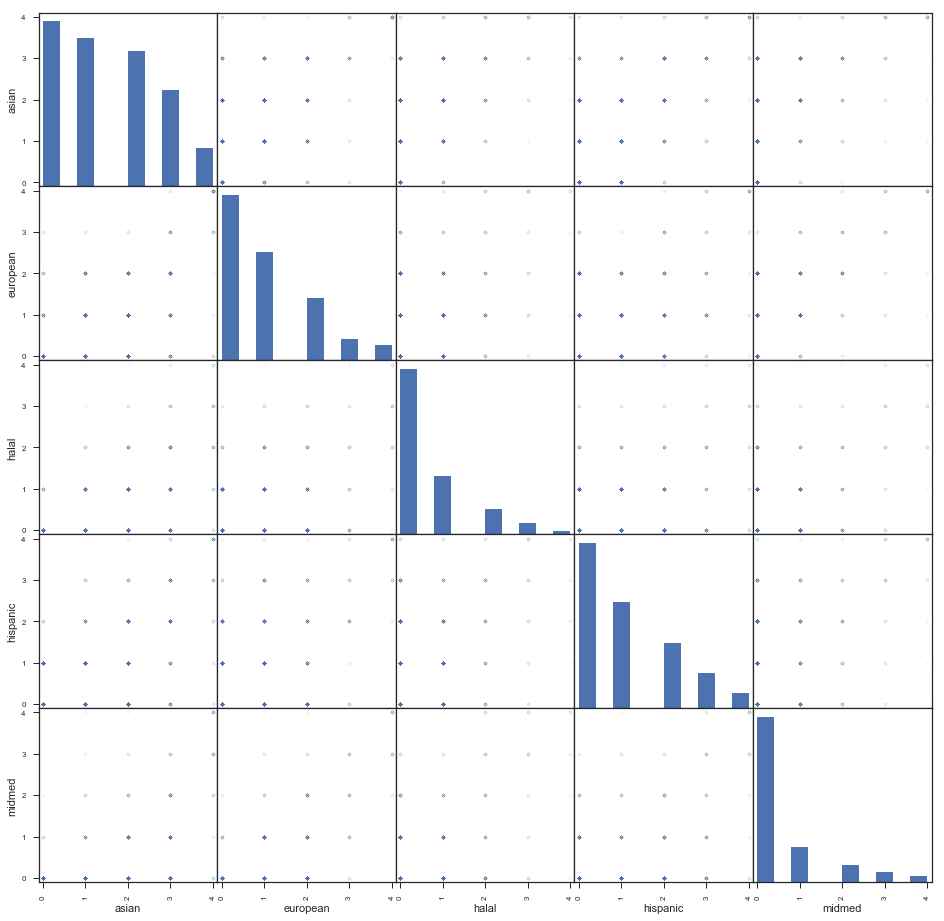

In [19]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(X, alpha=0.006, figsize=(16, 16), diagonal='hist');

In [44]:
ACS = pd.read_csv(DATA + '/features/ACSselectedData.csv', index_col=0)
Health = pd.read_csv(DATA + '/features/NYC_Health_Features.csv')
Yelp = pd.read_csv(DATA + '/yelp_counts_per_ct.csv', index_col=0)

In [45]:
MergedData = ACS.merge(Health, left_on='FIPS', right_on='TractFIPS', how='outer')
print(MergedData.shape)
MergedData.head()

(2167, 50)


,FIPS,Census Tract,Pop Density,Income,Age,Household Size,Total Pop,Mexican,Cuban,Dominican,...,Black or African American,American Indian and Alaska Native,Asian,Hispanic or Latino,PlaceFIPS,TractFIPS,Place_TractID,DIABETES_CrudePrev,HIGHCHOL_CrudePrev,OBESITY_CrudePrev
0,36005000100,100,11586.310,NaN,32.1,NaN,7503,1.865920,0.279888,5.077969,...,62.601626,0.186592,1.799280,29.854725,3651000.0,3.600500e+10,3651000-36005000100,9.9,27.8,35.4
1,36005000200,200,28365.120,70893.0,38.6,3.94,5251,3.865930,0.190440,12.816606,...,24.795277,0.000000,2.799467,74.957151,3651000.0,3.600500e+10,3651000-36005000200,12.7,33.8,29.9
2,36005000400,400,20096.470,76667.0,39.4,3.10,5980,1.672241,1.521739,13.244147,...,33.762542,0.317726,0.953177,64.682274,3651000.0,3.600500e+10,3651000-36005000400,11.2,31.4,29.4
3,36005001600,1600,32334.870,31540.0,36.9,2.94,6056,0.577939,1.469617,29.920740,...,36.079921,0.000000,0.000000,66.727213,3651000.0,3.600500e+10,3651000-36005001600,17.0,37.8,34.5
4,36005001900,1900,4164.445,39130.0,32.5,2.27,2682,4.809843,0.000000,17.002237,...,37.061894,0.000000,1.864280,54.026846,3651000.0,3.600500e+10,3651000-36005001900,11.4,30.8,33.0


In [46]:
MergedData = MergedData.merge(Yelp, on='FIPS', how='outer', suffixes=('_ACS', '_Yelp'))
print(MergedData.shape)
MergedData.head()

(2168, 97)


,FIPS,Census Tract,Pop Density,Income,Age,Household Size,Total Pop,Mexican_ACS,Cuban_ACS,Dominican_ACS,...,Puerto Rican,Russian_Yelp,Salvadoran_Yelp,Shanghainese,Singaporean,Taiwanese_Yelp,Thai_Yelp,Turkish_Yelp,Venezuelan_Yelp,Vietnamese_Yelp
0,36005000100,100.0,11586.310,NaN,32.1,NaN,7503.0,1.865920,0.279888,5.077969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36005000200,200.0,28365.120,70893.0,38.6,3.94,5251.0,3.865930,0.190440,12.816606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36005000400,400.0,20096.470,76667.0,39.4,3.10,5980.0,1.672241,1.521739,13.244147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36005001600,1600.0,32334.870,31540.0,36.9,2.94,6056.0,0.577939,1.469617,29.920740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36005001900,1900.0,4164.445,39130.0,32.5,2.27,2682.0,4.809843,0.000000,17.002237,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
